## Notebook to explore data within the SADD (aircraft detection) dataset (JPG images, both YOLO v9 and COCO JSON annotation formats)
## ADDITION AT BOTTOM: Code for resizing original 224x224 image slices (from YOLOv11 v2 download, which was confirmed to be no different than the YOLOv9 v2 download orignally explored; i.e. images and annotation files identical but learning architecture different) to 200x200 for conformity among the different datasets we are using YOLOv11 to train with (currently HRSID ship dataset and this SADD airplane dataset); creating custom (randomized) split for train, validation and test sets and creating new directory and also performing some verifications to ensure that the process went through smoothly without need for additional considerations
## FURTHER ADDITION: Following realization of an warning related to 200x200 size with YOLOv11 training, modified code to create a third directory containing the original 224x224 slices but according to the same randomized train, validate,test split

In [20]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import glob

Because the original academic work as related to the GitHub page [here](https://github.com/hust-rslab/SAR-aircraft-data) utilized a YOLO format, this format is explored. The link provided directly on the GitHub page seemed troublesome, but within the "Issues" tab another GitHub user provided a separate Roboflow link which seemingly has the same dataset in various formats. From here the dataset was downloaded in both the YOLO v9 format, along with a COCO JSON format (as explored previously with HRSID). Dataset versions can be downloaded from [here](https://universe.roboflow.com/project-y2j81/hust-rslab-sar-aircraft-data/dataset/2). It should be noted that on top of the different formats, there are two overall versions for the dataset through Roboflow. For this notebook, v2 was utilized. About the v2 version, it should be noted that there are more images in the training set, less images in the validation set, and no images in the test set. There is no preprocessing of the data for v2. Conversely, in the v1 version, there are less images in the training set, more images in the validation validation set, and 84 images in the test set. There is also preprocessing already imposed on the v1 version, being "Auto-Orient" and resizing from 240x240 to 640x640. Once extracted, the v2 YOLO v9 format of the dataset is only 10.3 MB and the v2 COCO JSON format of the dataset is only 10.6 MB. For this notebook, I assume the following directory structure:
```
└───datasets
    └───SADD
        ├───hust-rslab-SAR-aircraft-data.v2i.yolov9
            ├───train
                ├───images
                └───labels
            ├───valid
                ├───images
                └───labels
            ├───data.yaml
            ├───README.dataset.txt
            └───README.roboflow.txt
        └───hust-rslab-SAR-aircraft-data.v2i.coco
            ├───train
                ├───...
                └───_annotations.coco.json
            ├───valid
                ├───...
                └───_annotations.coco.json
            ├───README.dataset.txt
            └───README.roboflow.txt
└───dataset_exploration
    └───SADD_exploration.ipynb
```

*** Since this initial exploration of the SADD dataset, Roboflow updated the SADD dataset page to reflect a YOLOv11 version for the newer YOLO architecture. The nature of the data (images and annotations) otherwise has not changed, but this should be noted in case we would like to utilize a newer YOLOv11 model in training. The v11 update lies in the architecture of the model for training and doesn't lie in a change in the structure of the images or .txt files used for labeling. It has been verified that the data itself has not changed whatsoever between the v9 download and the v11 download. By utilizing a v11 model, we may find improved performance (e.g., better feature extraction, faster inference, fewer parameters), but this is related to how the model processes the data, not the data itself.

In [21]:
# Modify as needed
dataset_path_YOLOv9 = os.path.join(r"/home", "tjriz", "Documents", "Senior-Design", "datasets", "SADD", "hust-rslab-SAR-aircraft-data.v2i.yolov9")
dataset_path_COCOJSON = os.path.join(r"/home", "tjriz", "Documents", "Senior-Design", "datasets", "SADD", "hust-rslab-SAR-aircraft-data.v2i.coco")

In [22]:
train_images_YOLOv9_path = os.path.join(dataset_path_YOLOv9, "train", "images")
train_images_COCOJSON_path = os.path.join(dataset_path_COCOJSON, "train")
train_annotations_YOLOv9_path = os.path.join(dataset_path_YOLOv9, "train", "labels")
train_annotations_COCOJSON_path = os.path.join(train_images_COCOJSON_path, "_annotations.coco.json")

yaml_path = os.path.join(dataset_path_YOLOv9, "data.yaml")

In [23]:
# Inspecting data.yaml file associated with the YOLOv9 format. It should be again noted that this v2 version of the YOLO formatted dataset does not 
# have the test image directory which appeared to be present within the v1 version
with open(yaml_path, 'r') as file:
    yaml_data = file.read()

print(yaml_data)

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['0']

roboflow:
  workspace: project-y2j81
  project: hust-rslab-sar-aircraft-data
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/project-y2j81/hust-rslab-sar-aircraft-data/dataset/2


In [24]:
# Due to nature of YOLO v9 dataset structure, handling in a different way than JSON
# Generate two lists of files which match by index (image/annotations). Ensure that using the glob module in this way generalizes to other OS systems
image_YOLOv9_files = glob.glob(os.path.join(train_images_YOLOv9_path, '*.jpg'))
annotation_YOLOv9_files = glob.glob(os.path.join(train_annotations_YOLOv9_path, '*.txt'))
# Sorting by numerical prefix
image_YOLOv9_files.sort()
annotation_YOLOv9_files.sort()

# Just ensuring that everything matches index-wise
for i in range(4):
    print(f"The current image file is: {image_YOLOv9_files[i]}")
    print(f"The current annotation file is: {annotation_YOLOv9_files[i]}")

# Ensuring that the number of image files and annotation files line up
print("Number of image files: ", len(annotation_YOLOv9_files))
print("Number of annotation files: ", len(annotation_YOLOv9_files))

The current image file is: /home/tjriz/Documents/Senior-Design/datasets/SADD/hust-rslab-SAR-aircraft-data.v2i.yolov9/train/images/00021_bmp.rf.96c5ddb7699a8bdeb4ff6fe4257181bb.jpg
The current annotation file is: /home/tjriz/Documents/Senior-Design/datasets/SADD/hust-rslab-SAR-aircraft-data.v2i.yolov9/train/labels/00021_bmp.rf.96c5ddb7699a8bdeb4ff6fe4257181bb.txt
The current image file is: /home/tjriz/Documents/Senior-Design/datasets/SADD/hust-rslab-SAR-aircraft-data.v2i.yolov9/train/images/00022_bmp.rf.60928c8c115630c8a95fe63dde2d2e48.jpg
The current annotation file is: /home/tjriz/Documents/Senior-Design/datasets/SADD/hust-rslab-SAR-aircraft-data.v2i.yolov9/train/labels/00022_bmp.rf.60928c8c115630c8a95fe63dde2d2e48.txt
The current image file is: /home/tjriz/Documents/Senior-Design/datasets/SADD/hust-rslab-SAR-aircraft-data.v2i.yolov9/train/images/00023_bmp.rf.a02ccd1cc2ab671da1d062912662ed9d.jpg
The current annotation file is: /home/tjriz/Documents/Senior-Design/datasets/SADD/hust-rsl

In [25]:
# Reading two random example images. Can play around with changing the indices here to ensure consistency across various images from 
# 0 to 732 indices.
# This cell is dedicated to YOLOv9 data format
idx_ex1 = 10
idx_ex2 = 455
image_1 = plt.imread(image_YOLOv9_files[idx_ex1])
image_2 = plt.imread(image_YOLOv9_files[idx_ex2])
# Retrieving corresponding annotation files
anno_file1 = annotation_YOLOv9_files[idx_ex1]
anno_file2 = annotation_YOLOv9_files[idx_ex2]

annotations_1 = []
annotations_2 = []

# Reading annotation data into a list for later use while also printing to visualize the structure of the data. As also shown on the GitHub page,
# this type of annotation data is of a more simplistic/bare-bones format, and should be suitable for the purposes of the airplane detection for which
# this dataset was created. Only bounding boxes, with object classes (all of which are 0 for airplanes)
with open(anno_file1, 'r') as file:
    print("Contents of first example YOLOv9 annotations file:")
    for line in file:
        print(line)
        values = line.strip().split()
        class_id = int(values[0])
        x_center, y_center, width, height = map(float, values[1:])
        annotations_1.append([class_id, x_center, y_center, width, height])
print()
with open(anno_file2, 'r') as file:
    print("Contents of second example YOLOv9 annotations file:")
    for line in file:
        print(line)
        values = line.strip().split()
        class_id = int(values[0])
        x_center, y_center, width, height = map(float, values[1:])
        annotations_2.append([class_id, x_center, y_center, width, height])

Contents of first example YOLOv9 annotations file:
0 0.14955357142857142 0.12946428571428573 0.12053571428571429 0.16071428571428573

0 0.4955357142857143 0.12946428571428573 0.14285714285714285 0.16071428571428573

0 0.671875 0.12053571428571429 0.12053571428571429 0.16071428571428573

0 0.8415178571428571 0.12053571428571429 0.11160714285714286 0.16964285714285715

0 0.16517857142857142 0.515625 0.13392857142857142 0.15625

0 0.32142857142857145 0.5133928571428571 0.13392857142857142 0.16071428571428573

0 0.5 0.5089285714285714 0.125 0.15178571428571427

0 0.6629464285714286 0.5089285714285714 0.13839285714285715 0.16071428571428573

0 0.8348214285714286 0.5111607142857143 0.13392857142857142 0.15625

0 0.9308035714285714 0.640625 0.12053571428571429 0.15625

Contents of second example YOLOv9 annotations file:
0 0.8325892857142857 0.06473214285714286 0.17410714285714285 0.12946428571428573


In [26]:
# Reading the COCO JSON data annotation file
with open(train_annotations_COCOJSON_path) as json_data:
    data_train_JSON = json.load(json_data)
    image_info_JSON = data_train_JSON['images']
    image_annotations_JSON = data_train_JSON['annotations']

In [27]:
# Ensuring that both formats contain the same number of images and the same number of total annotations

print("Number of images in COCO JSON:", len(image_info_JSON))
print("Number of annotations in COCO JSON:", len(image_annotations_JSON))

# Counting the number of YOLOv9 annotations
total_anno_YOLO = 0
for annotation_path in annotation_YOLOv9_files:
    # Open each annotation file and count the lines
    with open(annotation_path, 'r') as file:
        annotations = file.readlines()
        total_anno_YOLO += len(annotations)
print()        
print("Number of images in YOLOv9:", len(annotation_YOLOv9_files))
print("Number of annotations in YOLOv9:", total_anno_YOLO)

Number of images in COCO JSON: 733
Number of annotations in COCO JSON: 6471

Number of images in YOLOv9: 733
Number of annotations in YOLOv9: 6471


In [28]:
# Looked at sample image info from JSON data, using same indices as for YOLOv9. Images are unfortunately not ordered according to the numerical file 
# prefixes, so IDs here are different than the indices for the YOLO data (where I sorted based on the numerical prefix of images in directory,
# which do align among the two different datasets)
for key in image_info_JSON[idx_ex1].keys():
    print(key, ":", image_info_JSON[idx_ex1][key])
print()
for key in image_info_JSON[idx_ex2].keys():
    print(key, ":", image_info_JSON[idx_ex2][key])

id : 10
license : 1
file_name : 00100_bmp.rf.036e65ffb7543526e10d2854b123f8b2.jpg
height : 224
width : 224
date_captured : 2022-12-01T12:28:02+00:00

id : 455
license : 1
file_name : 01588_bmp.rf.991fe306f2d4050d703214404cfd8b82.jpg
height : 224
width : 224
date_captured : 2022-12-01T12:28:02+00:00


In [29]:
# Look at sample annotations for JSON data
for key in image_annotations_JSON[idx_ex1].keys():
    print(key, ":", image_annotations_JSON[idx_ex1][key])
print()
for key in image_annotations_JSON[idx_ex2].keys():
    print(key, ":", image_annotations_JSON[idx_ex2][key])

id : 10
image_id : 0
category_id : 1
bbox : [173, 193, 50, 31]
area : 1550
segmentation : []
iscrowd : 0

id : 455
image_id : 41
category_id : 1
bbox : [155, 90, 19, 11]
area : 209
segmentation : []
iscrowd : 0


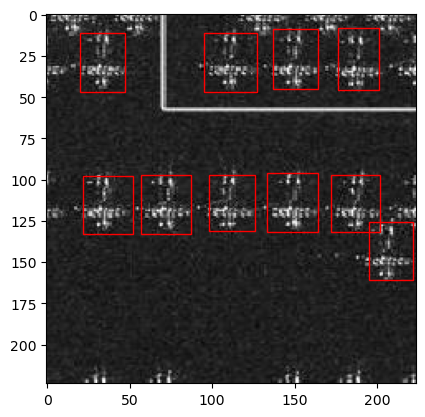

In [30]:
# Plot the first example image from YOLOv9 data
fig, ax = plt.subplots(1)
ax.imshow(image_1)

# Get first example image dimensions
img_height, img_width, _ = image_1.shape

# Plotting bounding boxes overlaying first example image, in accordance with YOLO format
for annotation in annotations_1:
    class_id, x_center, y_center, width, height = annotation

    # Convert from normalized to actual pixel values
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left corner of the bounding box for purposes of using patches.Rectangle
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

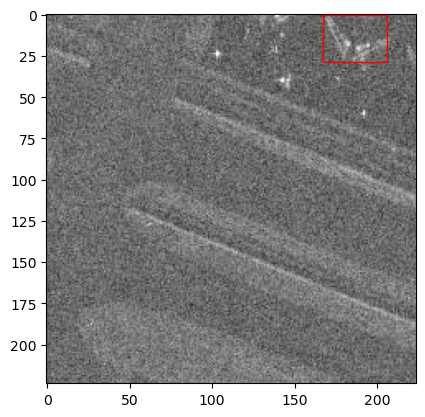

In [31]:
# Plot the second example image from YOLOv9 data
fig, ax = plt.subplots(1)
ax.imshow(image_2)

# Get second example image dimensions
img_height, img_width, _ = image_2.shape

# Plotting bounding boxes overlaying second example image, in accordance with YOLO format
for annotation in annotations_2:
    class_id, x_center, y_center, width, height = annotation

    # Convert from normalized to actual pixel values
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left corner of the bounding box for purposes of using patches.Rectangle
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

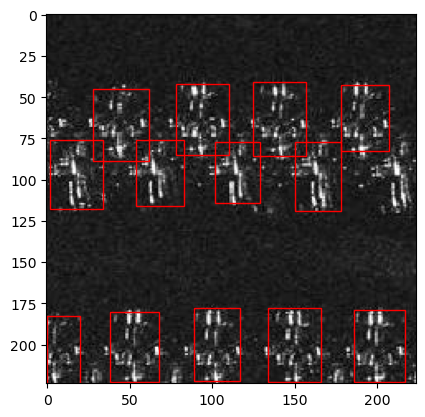

In [32]:
# Drawing bounding boxes in first random example image from JSON data (assumption that image IDs within JSON data would align with the numerical
# ordering of file prefixes, which ended up not being true; the following two examples are different than the preceding YOLO examples)
bboxes = []
for i in range(len(image_annotations_JSON)):
    if image_annotations_JSON[i]['image_id'] == idx_ex1:
        bboxes.append(image_annotations_JSON[i]['bbox'])

img_path = os.path.join(train_images_COCOJSON_path, image_info_JSON[idx_ex1]['file_name'])
fig, ax = plt.subplots()

for i in range(len(bboxes)):
    with Image.open(img_path) as img:
        ax.imshow(img)
        airplane_bbox = patches.Rectangle((bboxes[i][0], bboxes[i][1]), bboxes[i][2], bboxes[i][3],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(airplane_bbox)

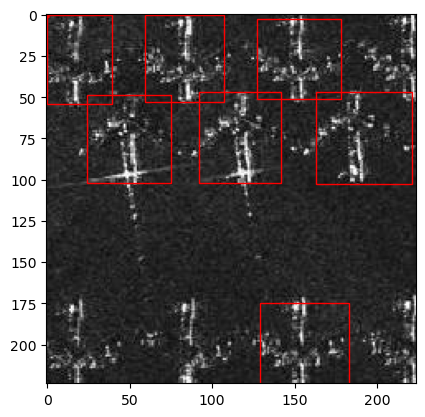

In [33]:
# Drawing bounding boxes in second random example image from JSON data (again the IDs in the JSON data doesn't align with the numerical
# ordering of the filenames)

bboxes = []
for i in range(len(image_annotations_JSON)):
    if image_annotations_JSON[i]['image_id'] == idx_ex2:
        bboxes.append(image_annotations_JSON[i]['bbox'])

img_path = os.path.join(train_images_COCOJSON_path, image_info_JSON[idx_ex2]['file_name'])
fig, ax = plt.subplots()

for i in range(len(bboxes)):
    with Image.open(img_path) as img:
        ax.imshow(img)
        airplane_bbox = patches.Rectangle((bboxes[i][0], bboxes[i][1]), bboxes[i][2], bboxes[i][3],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(airplane_bbox)

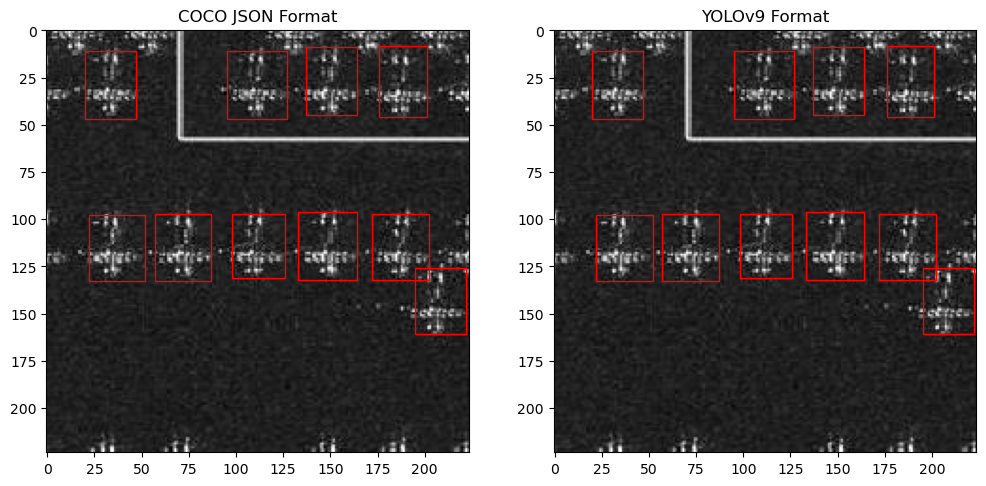

In [34]:
# Now finding the first example image that was used first with the YOLOv9 data from earlier, as the IDs within JSON didn't align with the ordering of the 
# numerical prefixes of the filenames. Comparing the two formats side-by-side.
idx_yolo = 0

for i in range(len(image_info_JSON)):
    if image_info_JSON[i]['file_name'] == os.path.basename(image_YOLOv9_files[idx_ex1]):
        idx_yolo = image_info_JSON[i]['id'];


bboxes = []
for i in range(len(image_annotations_JSON)):
    if image_annotations_JSON[i]['image_id'] == idx_yolo:
        bboxes.append(image_annotations_JSON[i]['bbox'])

img_path = os.path.join(train_images_COCOJSON_path, image_info_JSON[idx_yolo]['file_name'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(len(bboxes)):
    with Image.open(img_path) as img:
        ax1.imshow(img)
        airplane_bbox = patches.Rectangle((bboxes[i][0], bboxes[i][1]), bboxes[i][2], bboxes[i][3],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(airplane_bbox)
ax1.set_title('COCO JSON Format')

# Now plotting 
ax2.imshow(image_1)
ax2.set_title('YOLOv9 Format')

# Get first example image dimensions
img_height, img_width, _ = image_1.shape

# Plotting bounding boxes overlaying first example image, in accordance with YOLO format
for annotation in annotations_1:
    class_id, x_center, y_center, width, height = annotation

    # Convert from normalized to actual pixel values
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left corner of the bounding box for purposes of using patches.Rectangle
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)

    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
plt.show()

In [35]:
# As I noticed that somebody had utilized "Auto-Orient" in preprocessing this dataset, I wanted to ensure whether this was even
# necessary, and whether there were "orientation tags" attached to any of these images. We are now utilizing the dataset labeled
# as YOLOv11 (although I discovered that this is no different in content than the one used previously labeled as YOLOv9)

from PIL import ExifTags

# Path to the original YOLOv11 dataset, with 224x224 slices...previously in this notebook I was exploring the YOLOv9 version of this dataset
# and I came to discover that there is no difference in the actual dataset (in terms of image and YOLO-formatted annotation content) and that 
# the difference lies in the learning architecture itself
original_data_dir = os.path.join(r"/home", "tjriz", "Documents", "Senior-Design", "datasets", "SADD", "hust-rslab-SAR-aircraft-data.v2i.yolov11")

# Initialize a counter for images with orientation tags
orientation_counts = {}

# Get the EXIF orientation tag key
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        orientation_key = orientation
        break

# Iterate through all images in the directory
for img_file in os.listdir(os.path.join(original_data_dir, "train", "images")):
    img_path = os.path.join(train_images_YOLOv9_path, img_file)
    try:
        with Image.open(img_path) as img:
            # Check EXIF orientation tag if it exists
            exif = img._getexif()
            if exif and orientation_key in exif:
                orientation = exif[orientation_key]
                orientation_counts[orientation] = orientation_counts.get(orientation, 0) + 1
            else:
                orientation_counts["No Orientation Tag"] = orientation_counts.get("No Orientation Tag", 0) + 1
    except (AttributeError, KeyError, IndexError, IOError):
        print(f"Could not process {img_file}.")

# Output the orientation summary
print("Orientation Summary:")
for orientation, count in orientation_counts.items():
    print(f"Orientation {orientation}: {count} images")


Orientation Summary:
Orientation No Orientation Tag: 733 images


In [36]:
import random
from pathlib import Path
import shutil

output_resized_data_dir = os.path.join(r"/home", "tjriz", "Documents", "Senior-Design", "datasets", "SADD", "hust-rslab-SAR-aircraft-data.v2i.yolov11.resize200")
output_original_data_dir = os.path.join(r"/home", "tjriz", "Documents", "Senior-Design", "datasets", "SADD", "hust-rslab-SAR-aircraft-data.v2i.yolov11.newsplit")

# Target image size for resizing
target_size = (200, 200)

# Desired split ratios
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

# Function to clear existing files in a directory
def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

# Prepare output directories and clear any existing files for both resized and original datasets
for output_dir in [output_resized_data_dir, output_original_data_dir]:
    for split in ['train', 'valid', 'test']:
        image_dir = os.path.join(output_dir, split, 'images')
        label_dir = os.path.join(output_dir, split, 'labels')
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)
        clear_directory(image_dir)  # Clear existing images
        clear_directory(label_dir)  # Clear existing labels

# Get all image files and corresponding label files
image_files = list(Path(original_data_dir, 'train/images').glob('*.jpg')) + \
              list(Path(original_data_dir, 'valid/images').glob('*.jpg'))

# Shuffle the dataset and split into train, valid, and test sets
random.shuffle(image_files)
train_end = int(len(image_files) * train_ratio)
valid_end = train_end + int(len(image_files) * valid_ratio)

train_files = image_files[:train_end]
valid_files = image_files[train_end:valid_end]
test_files = image_files[valid_end:]

# Function to process files for both resized and original directories
def process_files(files, split):
    for img_path in files:
        # Define paths
        label_path = img_path.with_suffix('.txt').as_posix().replace('images', 'labels')
        
        # Process for resized directory
        with Image.open(img_path) as img:
            resized_img = img.resize(target_size, Image.LANCZOS)  # Use LANCZOS for high-quality downsampling
            resized_img.save(os.path.join(output_resized_data_dir, split, 'images', img_path.name))
        
        # Process for original 224x224 directory (copy without resizing)
        shutil.copy(img_path, os.path.join(output_original_data_dir, split, 'images', img_path.name))

        # Copy the annotation file to both directories
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(output_resized_data_dir, split, 'labels', os.path.basename(label_path)))
            shutil.copy(label_path, os.path.join(output_original_data_dir, split, 'labels', os.path.basename(label_path)))

# Process and save images and labels for each split
process_files(train_files, 'train')
process_files(valid_files, 'valid')
process_files(test_files, 'test')

print("Dataset preparation complete. Both resized and original images are stored separately.")


Dataset preparation complete. Both resized and original images are stored separately.


In [37]:
# === Verification ===
# Collect all image filenames from the original dataset (train and valid splits)
original_files = set()
for split in ['train', 'valid']:
    original_images_dir = Path(original_data_dir, split, 'images')
    for img_path in original_images_dir.glob('*.jpg'):
        original_files.add(img_path.name)

# Track any issues found
missing_files_resized = []
incorrect_size_files_resized = []
missing_files_original = []
incorrect_size_files_original = []

# Verify each original file exists and is correctly sized in both new datasets
for original_filename in original_files:
    # Check resized dataset (new directory)
    file_found_resized = False
    for split in ['train', 'valid', 'test']:
        resized_image_path = Path(output_resized_data_dir, split, 'images', original_filename)
        if resized_image_path.exists():
            file_found_resized = True
            with Image.open(resized_image_path) as img:
                if img.size != (200, 200):
                    incorrect_size_files_resized.append(resized_image_path)
            break
    if not file_found_resized:
        missing_files_resized.append(original_filename)

    # Check newly split 224x224 dataset (new directory)
    file_found_original = False
    for split in ['train', 'valid', 'test']:
        original_image_path = Path(output_original_data_dir, split, 'images', original_filename)
        if original_image_path.exists():
            file_found_original = True
            with Image.open(original_image_path) as img:
                if img.size != (224, 224):
                    incorrect_size_files_original.append(original_image_path)
            break
    if not file_found_original:
        missing_files_original.append(original_filename)

# Report results for resized dataset, within new directory
print("\n--- Verification for Resized 200x200 Dataset ---")
if missing_files_resized:
    print(f"Missing files in the new directory containing resized dataset: {missing_files_resized}")
else:
    print("All original files are accounted for in the new directory with resized dataset.")
if incorrect_size_files_resized:
    print("Files with incorrect dimensions in the new directory with resized dataset:")
    for file in incorrect_size_files_resized:
        print(f"{file} (Expected 200x200)")
else:
    print("All resized files in the new directory have the correct dimensions of 200x200.")

# Report results for 224x224 dataset, newly split, in new directory
print("\n--- Verification for Newly Split 224x224 Dataset ---")
if missing_files_original:
    print(f"Missing files in the new directory containing the newly split 224x224 dataset: {missing_files_original}")
else:
    print("All original files are accounted for within the directory for the newly split 224x224 dataset.")
if incorrect_size_files_original:
    print("Files with incorrect dimensions in the directory for the newly split 224x224 dataset:")
    for file in incorrect_size_files_original:
        print(f"{file} (Expected 224x224)")
else:
    print("All files in the new directory have the correct dimensions of 224x224.")


--- Verification for Resized 200x200 Dataset ---
All original files are accounted for in the new directory with resized dataset.
All resized files in the new directory have the correct dimensions of 200x200.

--- Verification for Newly Split 224x224 Dataset ---
All original files are accounted for within the directory for the newly split 224x224 dataset.
All files in the new directory have the correct dimensions of 224x224.


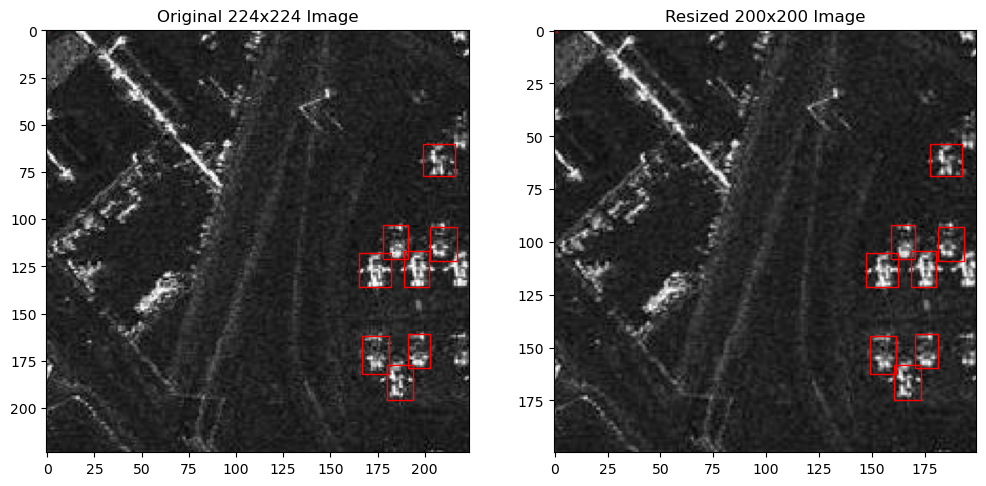

In [43]:
# Choose a random split and a random image within that split in the resized dataset
split = random.choice(['train', 'valid', 'test'])
resized_images_dir = Path(output_resized_data_dir, split, 'images')
resized_labels_dir = Path(output_resized_data_dir, split, 'labels')

# Pick a random image
resized_image_path = random.choice(list(resized_images_dir.glob('*.jpg')))
resized_label_path = resized_labels_dir / resized_image_path.with_suffix('.txt').name

# Determine the original split directory (only "train" or "valid")
original_split_dir = 'train' if (Path(original_data_dir, 'train', 'images') / resized_image_path.name).exists() else 'valid'
original_image_path = Path(original_data_dir, original_split_dir, 'images') / resized_image_path.name
original_label_path = Path(original_data_dir, original_split_dir, 'labels') / resized_label_path.name

# Load bounding box annotations
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        annotations = [list(map(float, line.split())) for line in f]
    return annotations

# Load annotations for both the original and resized images
original_annotations = load_annotations(original_label_path)
resized_annotations = load_annotations(resized_label_path)

# Display images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image with bounding boxes
with Image.open(original_image_path) as original_img:
    ax1.imshow(original_img)
    img_width, img_height = original_img.size
    for annotation in original_annotations:
        class_id, x_center, y_center, width, height = annotation
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        rect = patches.Rectangle((x_min, y_min), width * img_width, height * img_height, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
    ax1.set_title('Original 224x224 Image')

# Plot resized image with bounding boxes
with Image.open(resized_image_path) as resized_img:
    ax2.imshow(resized_img)
    img_width, img_height = resized_img.size
    for annotation in resized_annotations:
        class_id, x_center, y_center, width, height = annotation
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        rect = patches.Rectangle((x_min, y_min), width * img_width, height * img_height, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
    ax2.set_title('Resized 200x200 Image')

plt.show()
